In [48]:
%load_ext autoreload
%autoreload 2

import sys
sys.dont_write_bytecode = True

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
#imports
import os
import yaml
import json
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score
from catboost import CatBoostClassifier

from utils import plot_roc_curve
from utils import find_max_fscore 
from utils import plot_confusion_matrix
from utils import plot_feature_importnaces
from utils import plot_candletick_anomaly

In [50]:
#params
with open("params.yml", 'r') as file:
    params = yaml.safe_load(file)

root_path = params['root_path']
filepath_input = root_path + 'data/raw_data/'

feature_cols = ['close_price','n_trades','base_volume','buy_base']

shift_b = 18
shift_f = 7
anomaly_crtiretion = 1.0050

cb_params = {
    'iterations': 300,
    'learning_rate': 0.03,
    'depth': 5,
    'l2_leaf_reg': 2,
    'rsm': 0.7,
    'verbose': False,
    'allow_writing_files': False,
    'random_state': 42
}

In [51]:
###parsing json

files=os.listdir(filepath_input)

kline_js=[]
for name in files:
    f=open(filepath_input+name)
    js=json.load(f)
    for i in range(len(js)):
        kline_js.append(js[i])

E=[]
t_start=[]
t_end=[]
opens=[]
closes=[]
v=[]
n=[]
h=[]
l=[]
x=[]
q=[]
V=[]
Q=[]

for js_i in kline_js:

    if "stream" in js_i["r"] and js_i["r"]["stream"] == "btcusdt@kline_1m":

        try:
            E.append(js_i['r']['data']['E'])
            t_start.append(js_i['r']['data']['k']['t'])
            t_end.append(js_i['r']['data']['k']['T'])
            opens.append(float(js_i['r']['data']['k']['o']))
            closes.append(float(js_i['r']['data']['k']['c']))
            l.append(float(js_i['r']['data']['k']['l']))
            h.append(float(js_i['r']['data']['k']['h']))
            v.append(float(js_i['r']['data']['k']['v']))
            q.append(float(js_i['r']['data']['k']['q']))
            V.append(float(js_i['r']['data']['k']['V']))
            Q.append(float(js_i['r']['data']['k']['Q']))
            n.append(js_i['r']['data']['k']['n'])
            x.append(js_i['r']['data']['k']['x'])
            
        except:
            print(js_i)

d = {
    'event_time': E,
    't_start':t_start, 
    't_end':t_end, 
    'open_price':opens, 
    'close_price':closes,
    'low_price':l, 
    'high_price':h,
    'base_volume':v,
    'quote_volume':q, 
    'buy_base':V, 
    'buy_quote':Q, 
    'n_trades':n, 
    'is_closed':x,
    }

df = pd.DataFrame(data=d)

In [ ]:
###process

#correction_1
df['t_start'] = df['event_time']
df['t_end'] = df['event_time'].shift(-1)
df = df.dropna()

#correction_2
df = df.drop_duplicates('event_time', keep = 'first')
df = df.sort_values(by='event_time').reset_index(drop = True)
df = df.drop('event_time' , axis = 1)
df = df.dropna()

In [53]:
###generate features

#deltas
for col in feature_cols:
    df[f'{col}_delta'] = df[col].shift(-1) - df[col]
    
#correction_1 - отрицательные приросты из-за конца свечи
condition = (df['is_closed'] == True)
feature_cols_delta = [col + '_delta' for col in feature_cols]
for col_1, col_2 in zip(feature_cols,feature_cols_delta):
    df[col_2].loc[condition] = (df[col_1].loc[condition].values) + (df[col_2].loc[condition].values)

#correction_2 - отрицателные приросты из-за пропусков в датах 
cnd_2 = df['n_trades_delta'] < 0
df = df.drop(axis=0, index = df.loc[cnd_2].index)

#vol_per_trade
df['vol_per_trade'] = df['base_volume_delta'] / df['n_trades_delta']

#shift deltas
data_temp = pd.DataFrame()
for col in feature_cols_delta:
    for shift in range(shift_b+1):
        #deltas
        data_temp[f'{col}_{shift}'] = df[col].shift(shift)
        #cumsum deltas
        if shift > 1:
            data_temp[f'{col}_0_{shift-1}'] = df[col].rolling(shift).sum()
df = pd.concat([df.drop(feature_cols_delta, axis = 1), data_temp], axis = 1)
df = df.dropna()

#target
df['anomaly_t_start'] = np.where(
    df.close_price > df.open_price,
    df.high_price/df.open_price,
    df.open_price/df.low_price
    )
df['anomaly_t_end'] = df['anomaly_t_start'].shift(-shift_f)
df['target'] = df['anomaly_t_end'] > anomaly_crtiretion
df = df.dropna()

In [54]:
###select
dt_cols = ['t_start', 't_end']
price_cols = ['open_price','close_price','low_price','high_price']
feature_cols = feature_cols
delta_cols = [col for col in df.columns if 'delta' in col]

df_event = df[dt_cols + price_cols + ['target']].reset_index(drop = True)
df_period = df[dt_cols + delta_cols + ['target']].reset_index(drop = True)
df_model = df[delta_cols + ['target']].reset_index(drop = True)

In [55]:
#split
train, test = train_test_split(df_model, test_size = 0.2, random_state = 42, shuffle = False)

x_train = train.drop('target', axis = 1)
y_train = train.target.astype(int)

x_test = test.drop('target', axis = 1)
y_test = test.target.astype(int)

#fit best model
model = CatBoostClassifier(**cb_params)
model.fit(x_train, y_train)

# predict train probabilities
y_train_pred_proba = model.predict_proba(x_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

# predict test probabilities
y_test_pred_proba = model.predict_proba(x_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

#plot_find_max_fscore
opt_cutoff = find_max_fscore(y_test, y_test_pred_proba)

#calculate metrics
f_score_train = round(100*f1_score(y_train, (y_train_pred_proba > opt_cutoff), pos_label=1, average='binary'),2)
f_score_test  = round(100*f1_score(y_test , (y_test_pred_proba  > opt_cutoff), pos_label=1, average='binary'),2)

metrics_df = pd.DataFrame({'f_score_train':[f_score_train],
                           'f_score_test':[f_score_test]})

display(metrics_df)


,f_score_train,f_score_test
0,78.33,45.7


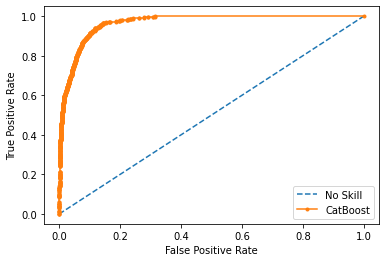

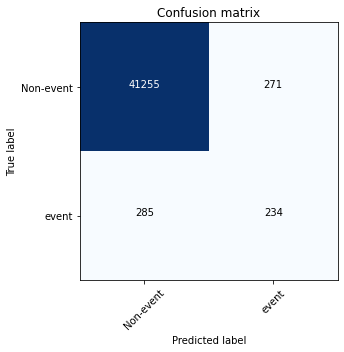

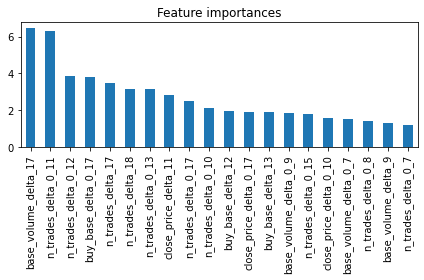

In [56]:
cutoff = opt_cutoff

# plot roc curve
plot_roc_curve(y_test, y_test_pred_proba)

#plot_confusion_matrix
plot_confusion_matrix(y_test, y_test_pred_proba, cutoff)

#plot_feature_importances
plot_feature_importnaces(model,x_train, top = 20)

In [57]:
# df_check = df_event[test.index[0]:]
# df_check = df_check.drop('target', axis = 1)

# df_check['true'] = y_test
# df_check['true'] = df_check['true'].astype(bool)

# df_check['predicted'] = (y_test_pred_proba  > opt_cutoff)
# df_check['predicted'] = df_check['predicted'].astype(bool)

# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots

# def plot_candletick_anomaly(df):
    
#     fig = make_subplots()
    
#     fig.add_scatter(
#         x = df[df['predicted'] == True]['t_start'],
#         y = df[df['predicted'] == True]['open_price'], mode = 'markers',
#         marker=dict(size=5, color="blue")
#     )
    
#     fig.add_scatter(
#         x = df[df['predicted'] == True]['t_start'],
#         y = df[df['predicted'] == True]['close_price'], mode = 'markers',
#         marker=dict(size=5, color="MediumPurple")
#     )

#     fig.add_trace(
#         go.Candlestick(
#             x=df['t_start'],
#             open=df['open_price'],
#             high=df['high_price'],
#             low=df['low_price'],
#             close=df['close_price']
#         ))
    
#     fig.show()
    
#     fig.write_image('candlestick.png')
    
# plot_candletick_anomaly(df_check)